# Movie Recommender System 

1. [Introduction](#intro)
2. [Data Analysis and Data Visualization](#eda)
3. [Recommendation engine by singular value decomposition](#svd)
    * [Implementation](#Implementation)
    * [Analysis](#Analysis)
    * [Recommendation based on my ranking](#Recommendation)

## Introduction <a class="anchor" id="intro"></a>
* Over the last few years I have been using the IMDb app to track and rank the movies I'm watching. After collecting and rating more than 500 movies, I thought it would be interesting to use this data to recommend movies for me.
* In this notebook, I use MovieLens 20M Dataset and my own personal ranking to create a recommendtion engine (and recommend movies for myself:) )

#### Dataset

The MovieLens dataset was downloaded from Kaggle: https://www.kaggle.com/grouplens/movielens-20m-dataset?select=movie.csv

* MovieLens datasets describe ratings from MovieLens, a movie recommendation service. 
* It contains 20000263 ratings across 27278 movies. 
* These data were created by 138493 users between January 09, 1995 and March 31, 2015. 
* My personal ranking dataset was creating using imdb Watchlist feature

#### The Algorithm
* There are many different ways to build recommendation systems. Often, simple solutions and implementations result in the best results. In this notebook, I will demonstrate an intuitive algorithm based on singular value decomposition.
* We will predict a rating for a user-movie pair based on the ratings given by other users to the same film. 

Steps:
1. Create a sprase $(n \times p)$ user-rating matrix $M$ with users as the index, movies as the columns and rating as values (0 is doesn't exists). Normalize the matrix such that every movie has a 0 mean rating.
2. Take the singular value decomposition of $M$: $M = U \Sigma V^T $ where $V$ is an orthogonal $p
\times p$ matrix (the columns of which are the eigenvectors of the covariance matrix of movies), $U$ is an $n \times n$  orthogonal matrix and $\Sigma$ is a (sorted) $n \times p$ dignoals matrix.
3. The columns of $V$ are vectors in $R^p$ representing weights for each film and are view as "factors" (or principal components)
4. We then take only k columns of $V$, $V_k$, and map each user ranknig row-vector $M_i$ (rows of M) to: $M_i \to M_i V_k V^T_k$, thereby projecting each user into a $k$-dimensional subspace.

##### Import libraries

In [417]:
# data analysis
import pandas as pd
import numpy as np
import time

# svd:
from scipy.sparse.linalg import svds
from scipy.sparse import csr_matrix

# visualization
import seaborn as sns
import matplotlib.pyplot as plt


# visualization settings
CMAP,fontfamily, context  = 'vlag',  "monospace", "notebook"
color_main = 'gold'
my_colors = [color_main, 'salmon', 'wheat', 'red']
rc = {'axes.titlesize':18, 'axes.titleweight':'bold',
      'axes.labelweight':'bold', 'figure.figsize':[12,8], 
      'lines.linewidth':5, 'axes.edgecolor':'black',
     'boxplot.boxprops.color': color_main}
sns.set(context=context, font=fontfamily, rc=rc, style="whitegrid")
sns.set_palette(CMAP)

#### Import data

In [449]:
# movies and moviesId
movieId = pd.read_csv("./data/movie.csv")

# users ratings
rating =  pd.read_csv("./data/rating.csv")

# link between imdb and MovieLens
link = pd.read_csv("./data/link.csv")

In [450]:
# str to timestamp
rating["timestamp"] = pd.to_datetime(rating["timestamp"])

# extract year from title name
movieId["year"] = movieId["title"].str.extract('\(([0-9]{4})\)', expand=False)

# adds rating to each film
movieId = movieId.merge(rating.groupby("movieId")["rating"].agg({"mean", "count"}), how='left', on='movieId')
movieId.columns = ["movieId", "title", "genres", "year", "user_rating", "total_votes"]

## Data Analysis and Data Visualization <a class="anchor" id="eda"></a>
* There 20M ratings, from 140k users across 27k movies

In [420]:
display(rating.head())
display(movieId.head())
print(f"size movieId: {movieId.shape}")
print(f"size rating: {rating.shape}")
users, movies = rating["userId"].nunique(), rating["movieId"].nunique()
print(f"Number of movies = {movies}")
print(f"Number of users = {users}")
print(f"The average number of movies rated by users = {users/movies:.2f}")
print(f'range of rating: {sorted(rating["rating"].unique())}')

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


size movieId: (27278, 3)
size rating: (20000263, 4)
Number of movies = 26744
Number of users = 138493
The average number of movies rated by users = 5.18
range of rating: [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]


* The number of movies rated by each user and the number of rating per movie are both heavily right skewed (e.g., more than 9k ratings for the most active users, while 68 is the median)
* 50% of the films gets a rating between 2.8 and 3.5

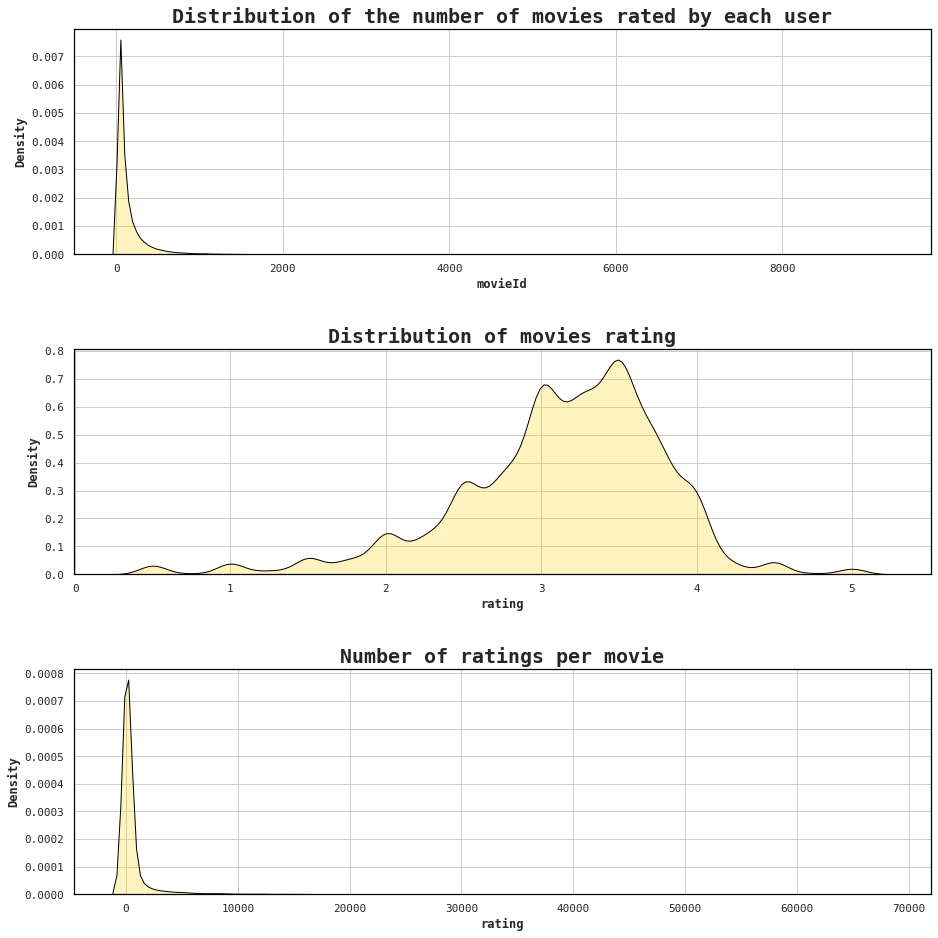

In [502]:
fig, ax = plt.subplots(ncols=1, nrows=3, figsize=(13,13))
ax = ax.flatten()

rating.groupby("userId")['movieId'].size()

title = "Distribution of the number of movies rated by each user"
sns.kdeplot(data=rating.groupby("userId")["movieId"].size(),shade=True, edgecolor="black",color=color_main, ax=ax[0]).set_title(title, fontsize=20)

title = "Distribution of movies rating"
sns.kdeplot(data=rating.groupby("movieId")["rating"].mean(),shade=True, edgecolor="black", color=color_main, ax=ax[1]).set_title(title,fontsize=20)
plt.savefig(f"./images/{title}.png") 


title = "Number of ratings per movie"
sns.kdeplot(data=rating.groupby("movieId")["rating"].size(),shade=True, edgecolor="black",  color=color_main, ax=ax[2]).set_title(title,fontsize=20)

plt.tight_layout(pad=0.5, w_pad=0.7, h_pad=3.0)

In [7]:
# number of movies rated by each user:
rating.groupby("userId")["movieId"].size().describe()

count    138493.000000
mean        144.413530
std         230.267257
min          20.000000
25%          35.000000
50%          68.000000
75%         155.000000
max        9254.000000
Name: movieId, dtype: float64

In [8]:
# number of votes per movie
rating.groupby("movieId")["rating"].size().describe()

count    26744.000000
mean       747.841123
std       3085.818268
min          1.000000
25%          3.000000
50%         18.000000
75%        205.000000
max      67310.000000
Name: rating, dtype: float64

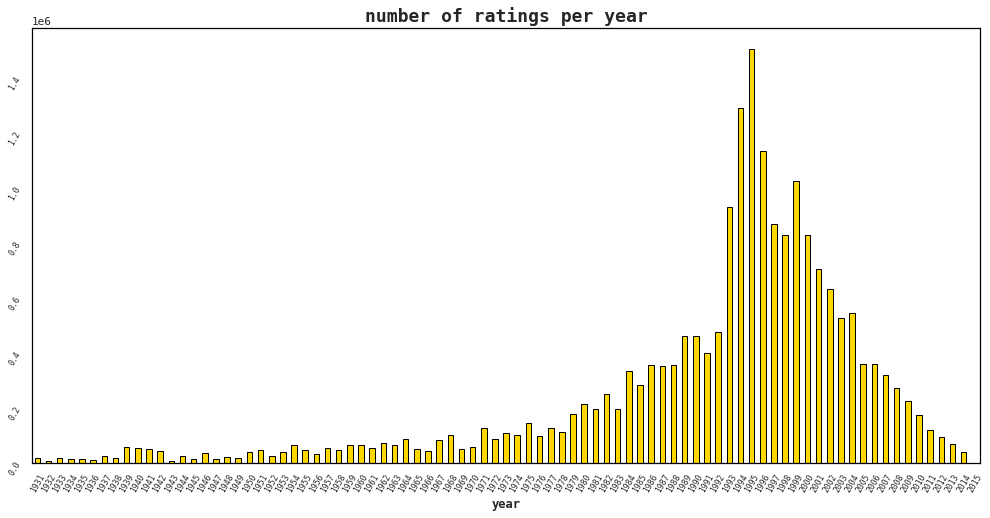

In [460]:
title = "number of ratings per year"
movie_year = rating.groupby("movieId")["rating"].agg({"mean", "count"}).merge(movieId, how='left', on='movieId')[["title", "mean", "count", "year"]]
tmp = movie_year.groupby("year")["count"].sum().dropna()
tmp.index = tmp.index.astype(int)
tmp = tmp[tmp.index > 1930]

ax = tmp.plot(kind="bar",color=color_main, edgecolor="black",grid=False, figsize=(17,8))
ax.set_title(title)
ax.tick_params(labelrotation=60, labelsize=8)

Text(0.5, 1.0, 'number of ratings per year')

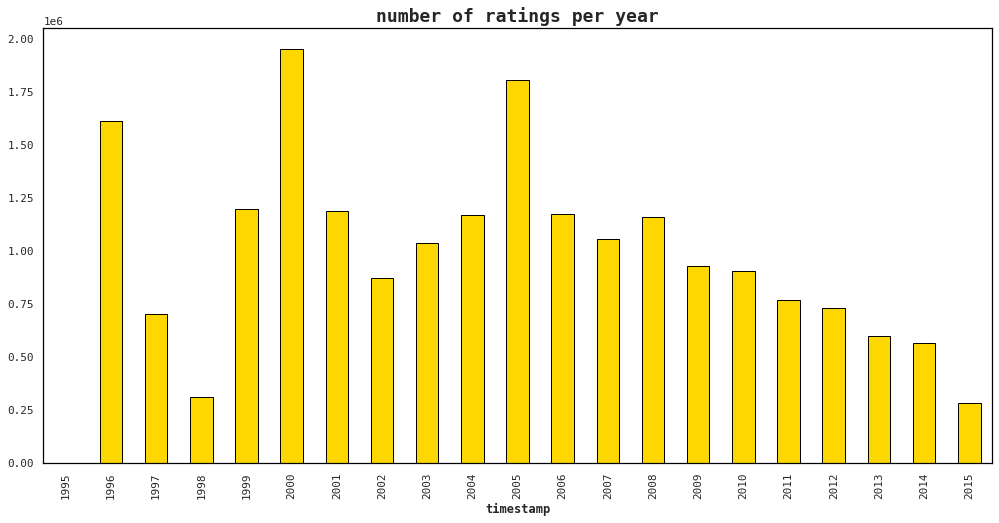

In [445]:
title = "number of ratings per year"
ax = rating.groupby(rating.timestamp.dt.year).size().plot(kind="bar",edgecolor="black",color=color_main, grid=False, figsize=(17,8))
ax.set_title(title)

**Rank all movies**

In [458]:
min_votes = 10000
movieId[movieId["total_votes"] > min_votes][["title", "user_rating", "total_votes"]].sort_values("user_rating", ascending=False).head(10)

,title,user_rating,total_votes
315,"Shawshank Redemption, The (1994)",4.446990,63366.0
843,"Godfather, The (1972)",4.364732,41355.0
49,"Usual Suspects, The (1995)",4.334372,47006.0
523,Schindler's List (1993),4.310175,50054.0
1195,"Godfather: Part II, The (1974)",4.275641,27398.0
1935,Seven Samurai (Shichinin no samurai) (1954),4.274180,11611.0
887,Rear Window (1954),4.271334,17449.0
895,Casablanca (1942),4.258327,24349.0
1169,One Flew Over the Cuckoo's Nest (1975),4.248079,29932.0
737,Dr. Strangelove or: How I Learned to Stop Worr...,4.247287,23220.0


## Recommendation engine by singular value decomposition <a class="anchor" id="svd"></a>

### Implementation <a class="anchor" id="Implementation"></a>
Steps:
1. Create a sprase $(n \times p)$ user-rating matrix $M$ with users as the index, movies as the columns and rating as values (0 is doesn't exists). Normalize the matrix such that every movie has a 0 mean rating.
2. Take the singular value decomposition of $M$: $M = U \Sigma V^T $ where $V$ is an orthogonal $p
\times p$ matrix (the columns of which are the eigenvectors of the covariance matrix of movies), $U$ is an $n \times n$  orthogonal matrix and $\Sigma$ is a (sorted) $n \times p$ dignoals matrix.
3. The columns of $V$ are vectors in $R^p$ representing weights for each film and are view as "factors" (or principal components)
4. We then take only k columns of $V$, $V_k$, and map each user ranknig row-vector $M_i$ (rows of M) to: $M_i \to M_i V_k V^T_k$, thereby projecting each user into a $k$-dimensional subspace. The result is a prediction vector for this user

In [477]:
def create_pivot_table(rating_mat, verbose=True):
    """ generates a pivot table with usres on the index and movies on the column and values being the ratings """
    if verbose: start = time.time()
    pivot_table = rating_mat.pivot(index='userId', columns='movieId', values='rating')

    pivot_table = pivot_table.dropna(how="all").fillna(0)
    if verbose:
        end = time.time()
        print(f"time to create pivot table: {(end - start):.2f}[sec]")
    return pivot_table

def matrix_factorization(mat, k=10, verbose=True):
    u, s, v = svds(mat, k = k, which="LM")
    
    if verbose: start = time.time()
    s = np.diag(s)
    if verbose:
        end = time.time()
        print(f"time to factor pivot table: {(end - start):.2f}[sec]")
    return u,s,v

def create_ratings_prediction_df(pivot_table, k=10, norm=True, verbose=True):
    # matrix factorization
    users = pivot_table.index
    moviesId = pivot_table.columns
    
    mat = pivot_table.values
    mat = csr_matrix(mat)
    u, s, v = matrix_factorization(mat, k, verbose)
    
    # always choose the eigenvector with average positive values:
    for pc_inx in range(v.shape[0]):
        if np.sum(v[pc_inx]) < 0:
            v[pc_inx] = -1.0*v[pc_inx]
    
    # goes back to the pivot-rating space:
    pred_ratings = pd.DataFrame((mat@v.T)@v)
    #if norm: pred_ratings = (pred_ratings - pred_ratings.min()) / (pred_ratings.max() - pred_ratings.min())
    
    pred_ratings.columns = moviesId
    pred_ratings.index = users
    
    return pred_ratings, mat, v, s

def get_users_prediction(pred_ratings, userId, moviesId_seen=[], n_films=5):
    user_pred = pred_ratings.loc[userId].sort_values(ascending=False).reset_index()
    return user_pred[~user_pred['movieId'].isin(moviesId_seen)].merge(movieId, on="movieId")["title"][:n_films].values


def pred(vec, pivot_table):
    """ predict for a single user """
    predicted_score = pd.DataFrame(((vec.T@v.T)@v).T, index = pivot_table.columns, columns=['predicted_score'])
    predicted_score = predicted_score.merge(movieId, how='inner', left_on=predicted_score.index.astype(int), right_on='movieId').sort_values('predicted_score', ascending=False)
    return predicted_score

In [462]:
# create new one, or load from cache:
create_new_pivot = False

if create_new_pivot:
    # creating a pivot table takes time.
    # for demonstration purposes sample only part of the users for training:
    n_users = 10000
    users_to_sample = np.random.choice(rating.userId.unique(), size=n_users)
    rating_sample = rating[rating.userId.isin(users_to_sample)]  
    
    pivot_table = create_pivot_table(rating_sample)
    
    # normalize for zero mean to each film
    pivot_table = pivot_table-pivot_table.mean()
    pivot_table.to_csv("./pivot_table.csv")

else: # load from cache:
    # load data from csv:
    pivot_table = pd.read_csv("./pivot_table.csv")
    pivot_table = pivot_table.set_index("userId")

time to create pivot table: 5.34[sec]


In [478]:
# make prediction
pred_ratings, mat, v, s = create_ratings_prediction_df(pivot_table)

time to factor pivot table: 0.00[sec]


### Analysis  <a class="anchor" id="Analysis"></a>
First I'd like to understand what each principal components capture (at least give basic interpretation). 

#### Principal component and movie count
* it seems the relative weights of movies in the first principal components corresponses to the number of overall votes to that movie
* This means, if we take only one principal component (k=1), our recommender will recommend popular-films (in terms of number of votes) to users who generally rank high popular films
* Toy Story is the film with the highest weight

In [482]:
pc_df = {f"PC{i}":v[i] for i in range(v.shape[0])}
pc_df["movieId"] = pred_ratings.columns
pc_df = pd.DataFrame(pc_df).merge(movieId, on="movieId")

,title,PC1
0,Toy Story (1995),0.055200
1,Jumanji (1995),0.029196
2,Grumpier Old Men (1995),0.008281
3,Waiting to Exhale (1995),0.001778
4,Father of the Bride Part II (1995),0.006118
...,...,...
15320,The Conrad Boys (2006),0.000054
15321,Light Gradient (2009),0.000020
15322,The Beautiful Story (1992),-0.000028
15323,That Sugar Film (2014),0.000119


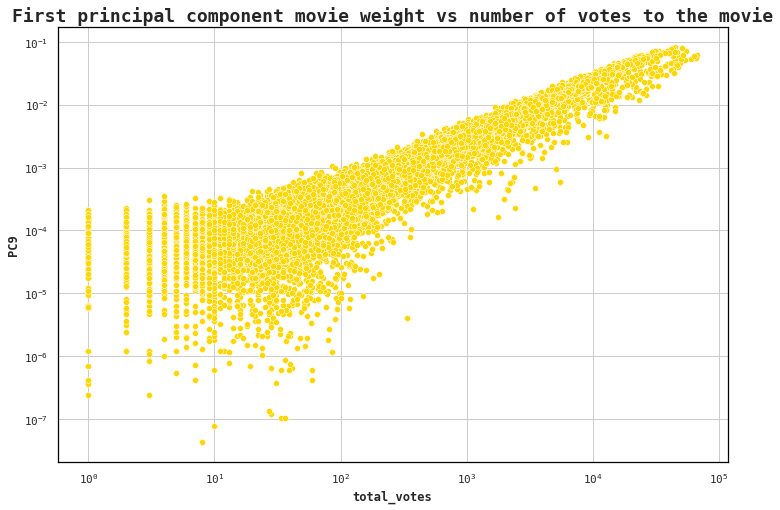

In [501]:
# rank all movies based on their weight in the first principal component
ax = sns.scatterplot(data=pc_df, x="total_votes", y="PC9", color=color_main)
title = "First principal component movie weight vs number of votes to the movie"
ax.set_title(title)
ax.set(yscale="log", xscale="log")
plt.savefig(f"./images/{title}.png") 

display(weighted_pc1[["title", "PC1"]])


### Recommendation based on my ranking <a class="anchor" id="Recommendation"></a>
**Load my ranking**

In [496]:
# download my films from IMDb
user = 'hila'
my_films = pd.read_csv(f"./data/personal_lists/{user}.csv")[["Title","Your Rating","Year", "Const"]]
my_films["Title"] = my_films["Title"].apply(lambda x:x.replace("The ", ""))

# drop films with no rating
my_films = my_films.dropna()

# drop films released after 2015, as we only have record until 2015.
my_films = my_films[my_films["Year"] < 2016]

# normalized ranking to from (1-10) to (0.5 - 5)
my_films["Your Rating"] = my_films["Your Rating"]/2.0

# link between imdb movieId to out data movieId, using the link.csv dataset
my_films["imdb_movieId"] = my_films["Const"].apply(lambda x:int(x.replace("tt", "")))
def imdb_movieId_to_movieId(imdb_movieId):
    try:
        return link[link.imdbId == imdb_movieId].movieId.values[0]
    except:
        return
my_films["movieId"] = my_films["imdb_movieId"].apply(imdb_movieId_to_movieId)
my_films = my_films.dropna()
my_films["movieId"] = my_films["movieId"].astype(int)
my_ranking_dict = my_films.dropna().set_index('movieId').to_dict()['Your Rating']

# finally, embed the list into the movies-space  
def embed_imdb_list_in_movies_space(my_films_dict): return np.array([my_films_dict[idx] if idx in my_films_dict.keys() else 0 for idx in [int(i) for i in pivot_table.columns if 'userId' != i]])
my_vec = embed_imdb_list_in_movies_space(my_ranking_dict).reshape(-1, 1)

**Generate a prediction**

In [497]:
# create prediction
predicated_score = pred(my_vec, pivot_table)
predicated_score = predicated_score.merge(my_films, how="left", on='movieId')

**recommendation vs actual ratings**

Let's evulate the performance of the recommendation by first predicting the ranking of movies I already seen. I compare the top and bottom 10 films recommaneded that I have seen against my own ranking

The prediction seems to work out pretty good!
* All of the top 10 recommended films were actually ranked 4.5 and above (i.e. top 25% of films)
* All of the bottom 10 recommended films were actually ranked 4.5 and above (i.e. bottom 25% of films)

In [498]:
predicated_score_with_rank = predicated_score[~predicated_score['Your Rating'].isnull()][["title", "year", "Your Rating"]]
display(predicated_score_with_rank.head(10))
display(predicated_score_with_rank.tail(10))

,title,year,Your Rating
0,Pulp Fiction (1994),1994,5.0
1,Fight Club (1999),1999,4.5
2,Reservoir Dogs (1992),1992,5.0
3,"Usual Suspects, The (1995)",1995,4.5
4,"Godfather, The (1972)",1972,4.5
5,Memento (2000),2000,4.5
6,Goodfellas (1990),1990,4.5
7,"Shawshank Redemption, The (1994)",1994,4.5
8,Eternal Sunshine of the Spotless Mind (2004),2004,5.0
9,"Dark Knight, The (2008)",2008,2.5


,title,year,Your Rating
10125,Scary Movie 5 (Scary MoVie) (2013),2013,4.0
10686,"Hot Chick, The (2002)",2002,2.0
13322,Jurassic Park (1993),1993,2.0
14211,How to Lose a Guy in 10 Days (2003),2003,3.5
14444,Thunderball (1965),1965,3.5
14780,Star Wars: Episode I - The Phantom Menace (1999),1999,3.0
14884,"Spy Who Loved Me, The (1977)",1977,3.5
15039,What Women Want (2000),2000,3.5
15064,Pearl Harbor (2001),2001,3.0
15237,Tomorrow Never Dies (1997),1997,3.5


**recommendtion of movies not seen** 

now we prints the top films recommnded that I have not yet seen:

In [500]:
predicated_score_without_rank = predicated_score[predicated_score['Your Rating'].isnull()][["title", "year", "predicted_score", "user_rating"]].sort_values("predicted_score", ascending=False)
predicated_score_without_rank[["title", "year"]].head(25)

,title,year
30,Blade Runner (1982),1982
40,"Pan's Labyrinth (Laberinto del fauno, El) (2006)",2006
47,Little Miss Sunshine (2006),2006
51,"Lord of the Rings: The Two Towers, The (2002)",2002
52,"Lord of the Rings: The Fellowship of the Ring,...",2001
53,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),1995
54,Shaun of the Dead (2004),2004
58,Children of Men (2006),2006
59,Iron Man (2008),2008
63,Juno (2007),2007
